In [1]:
%cd C:\Users\debie\Documents\anaconda_space

C:\Users\debie\Documents\anaconda_space


# Answering Business Questions using SQL

In this guided project, we're going to practice using our SQL skills to answer business questions.

We'll be working with a modified version of a database called Chinook (https://github.com/lerocha/chinook-database). The Chinook database contains information about a fictional digital music shop - kind of like a mini-iTunes store.

The Chinook database contains information about the artists, songs, and albums from the music shop, as well as information on the shop's employees, customers, and the customers purchases. This information is contained in eleven tables. Here's a schema diagram for the Chinook database:
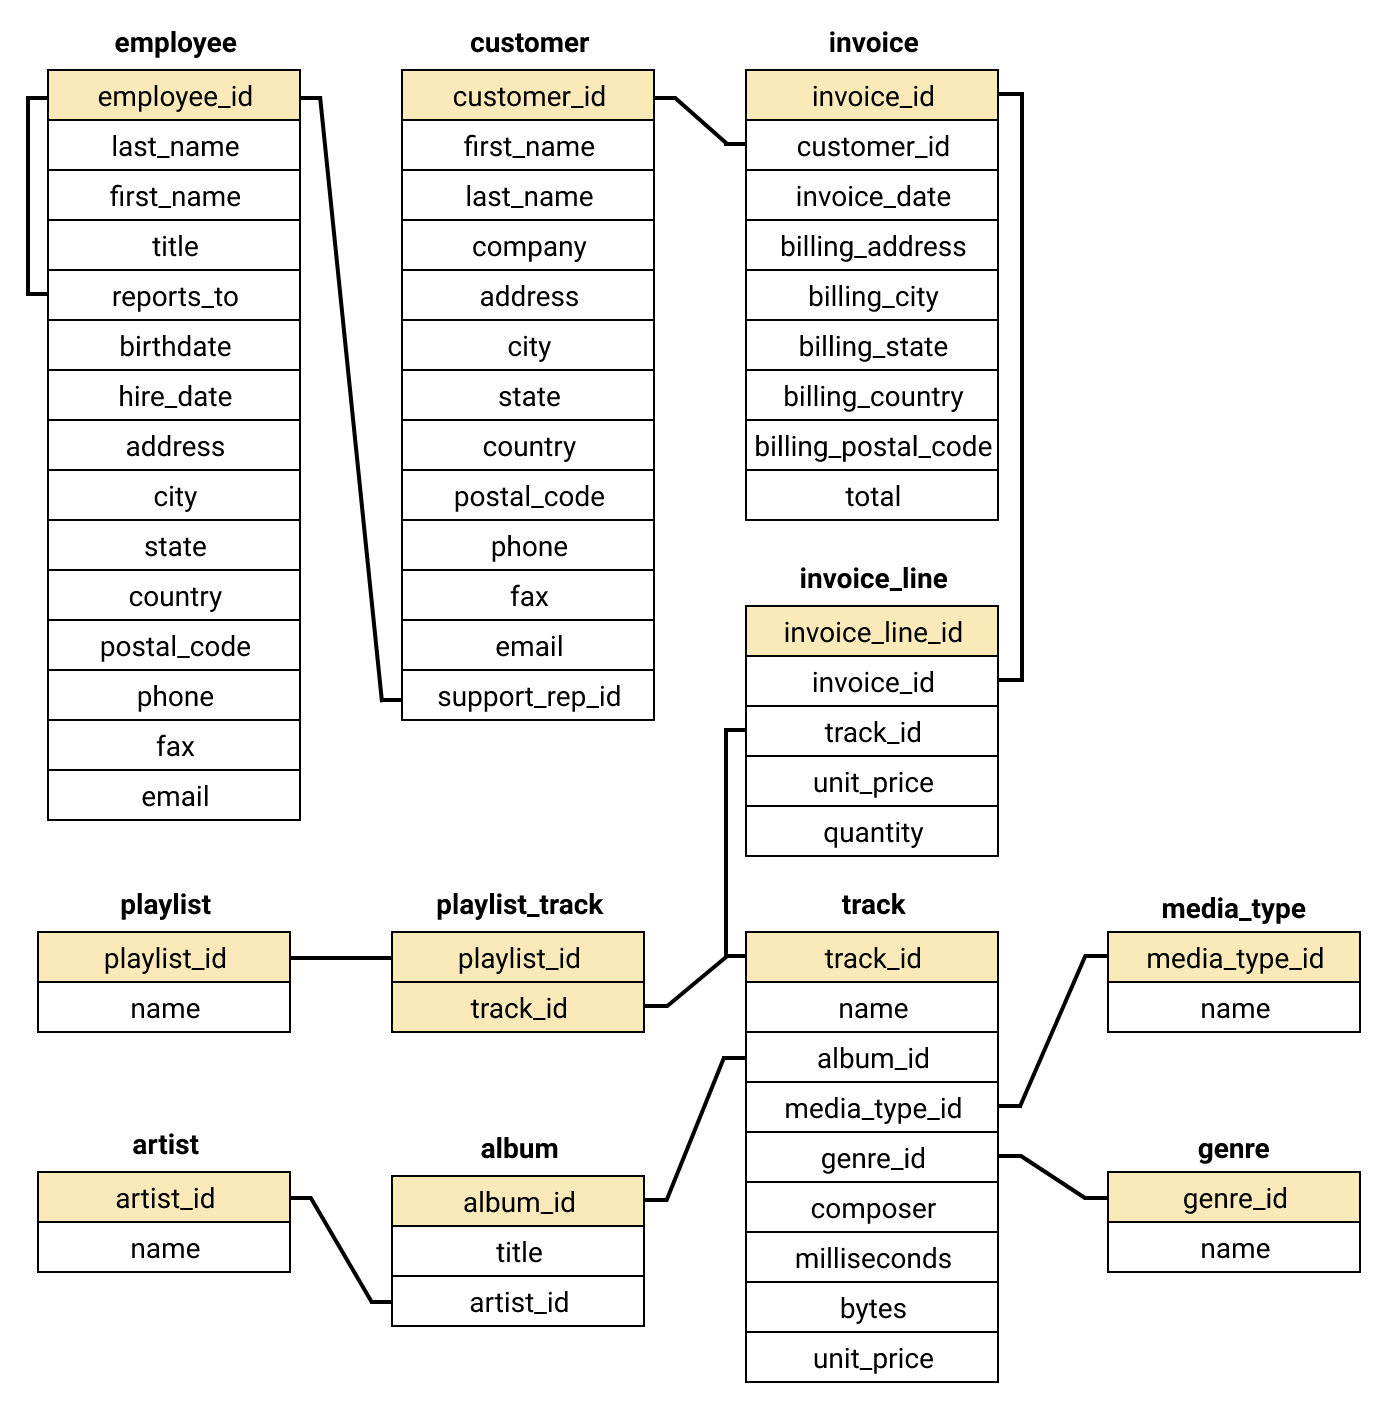

In [2]:
#First we open the database.

%%capture
%load_ext sql
%sql sqlite:///chinook.db

In [3]:
#Here we return a list of all tables and views in our databases.

%%sql
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view");

 * sqlite:///chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


### First question

The Chinook record store has just signed a deal with a new record label, and we've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

Artist: Regal  |  Genre: Hip-Hop

Artist: Red Tone  |  Genre: Punk

Artist: Meteor and the Girls  |  Genre: Pop

Artist: Slim Jim Bites  |  Genre: Blues



Let's get from the table each genre, with the number of tracks sold in the USA so that we can choose 3 albums from the list above.

In [4]:
%%sql
WITH invoice_us AS
(
SELECT invoice_id
  FROM invoice
 WHERE billing_country = 'USA'
),
ius AS
(
SELECT il.track_id track_id,
       il.quantity quantity
  FROM invoice_line il
INNER JOIN invoice_us iu ON iu.invoice_id = il.invoice_id
)


SELECT g.name genre,
       COUNT(ius.quantity) quantity,
       ROUND(CAST(COUNT(ius.quantity) AS FLOAT) / CAST(1051 AS FLOAT) * 100, 2) quantity_prct
  FROM ius
INNER JOIN track t ON t.track_id = ius.track_id
INNER JOIN genre g ON g.genre_id = t.genre_id
 GROUP BY genre
 ORDER BY quantity DESC;

 * sqlite:///chinook.db
Done.


genre,quantity,quantity_prct
Rock,561,53.38
Alternative & Punk,130,12.37
Metal,124,11.8
R&B/Soul,53,5.04
Blues,36,3.43
Alternative,35,3.33
Pop,22,2.09
Latin,22,2.09
Hip Hop/Rap,20,1.9
Jazz,14,1.33


We should purchase the artists with the genre Punk, Pop and Blues which are:

Artist: Red Tone  |  Genre: Punk

Artist: Meteor and the Girls  |  Genre: Pop

Artist: Slim Jim Bites  |  Genre: Blues

### Second question

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. We have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

In [5]:
%%sql
WITH customer_pur AS
(
SELECT customer_id,
       ROUND(SUM(total), 2) total_purchases
  FROM invoice
 GROUP BY customer_id
)

SELECT e.first_name || " " || e.last_name Salesman,
       ROUND(SUM(cp.total_purchases),2) 'Total sales',
       e.hire_date 'Hire date',
       COUNT(c.customer_id) 'Number of clients',
       ROUND(SUM(cp.total_purchases) / COUNT(c.customer_id),2) 'Sales per client'
  FROM employee e
LEFT JOIN customer c ON c.support_rep_id = e.employee_id
INNER JOIN customer_pur cp ON cp.customer_id = c.customer_id
GROUP BY e.employee_id;

 * sqlite:///chinook.db
Done.


Salesman,Total sales,Hire date,Number of clients,Sales per client
Jane Peacock,1731.51,2017-04-01 00:00:00,21,82.45
Margaret Park,1584.0,2017-05-03 00:00:00,20,79.2
Steve Johnson,1393.92,2017-10-17 00:00:00,18,77.44


There are 3 salesman in the company, we printed all the information needed to analyze their performance.

From the table printed above we can see that there is a link between the seniority of each salesman and the number and amount of sales they perform.

There is not a large difference between the salesman performance.

### Third question

The next task is to analyze the sales data for customers from each different country. We have been given guidance to use the country value from the customers table, and ignore the country from the billing address in the invoice table.

In particular, we have been directed to calculate data, for each country, on the:

    total number of customers
    total value of sales
    average value of sales per customer
    average order value


Now we will sort data on purchases by countries. When a country has only 1 customer we'll put it in a category named "Other".

In [6]:
%%sql
WITH base AS
(
SELECT c.country,
       c.customer_id,
       i.total
  FROM customer c
INNER JOIN invoice i ON i.customer_id = c.customer_id
),
cust_country AS
(
SELECT customer_id,
       country
  FROM base
 GROUP BY customer_id
),
number_country AS
(
SELECT country,
       COUNT(customer_id) 'Total number of customer'
  FROM cust_country
 GROUP BY country
),
tot_val_sale AS
(
SELECT country,
       ROUND(SUM(total), 2) 'Total value of sales'
  FROM base
 GROUP BY country
),
temp AS(
SELECT nc.country old_country,
       nc.'Total number of customer',
       tvs.'Total value of sales',
       CASE
           WHEN nc.'Total number of customer' = 1 THEN 'Other'
           ELSE nc.country
       END AS new_country
  FROM number_country nc
INNER JOIN tot_val_sale tvs ON tvs.country = nc.country),
temp_order AS
(
SELECT country,
       SUM(total) sum_order,
       COUNT(total) nbr_order
  FROM base
 GROUP BY country
),
almost AS
(
SELECT t.old_country,
       t.'Total number of customer',
       t.'Total value of sales',
       t.new_country,
       tor.nbr_order
  FROM temp t
INNER JOIN temp_order tor ON tor.country = t.old_country
),
final AS
(
SELECT a.new_country country,
       SUM(a.'Total number of customer') 'Total number of customer',
       SUM(a.'Total value of sales') 'Total value of sales',
       SUM(a.nbr_order) nbr_order
  FROM almost a        
 GROUP BY a.new_country
 ORDER BY a.'Total value of sales' DESC
)

SELECT fa.country 'Country',
       fa.'Total number of customer',
       fa.'Total value of sales',
       ROUND(fa.'Total value of sales' / fa.'Total number of customer', 2) 'Average value of sales per customer',
       ROUND(fa.'Total value of sales' / fa.nbr_order, 2) 'Average order value'
  FROM (SELECT f.*,
               CASE
                   WHEN f.country = 'Other' THEN 1
                   ELSE 0
               END AS sort
          FROM final f) fa
 ORDER BY sort;

 * sqlite:///chinook.db
Done.


Country,Total number of customer,Total value of sales,Average value of sales per customer,Average order value
USA,13,1040.49,80.04,7.94
Canada,8,535.59,66.95,7.05
Brazil,5,427.68,85.54,7.01
France,5,389.07,77.81,7.78
Germany,4,334.62,83.66,8.16
Czech Republic,2,273.24,136.62,9.11
United Kingdom,3,245.52,81.84,8.77
Portugal,2,185.13,92.57,6.38
India,2,183.15,91.58,8.72
Other,15,1094.94,73.0,7.45


### Fourth question

The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:

    purchase a whole album
    purchase a collection of one or more individual tracks.

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

In [41]:
%%sql 
WITH st_1 AS
(
SELECT i.invoice_id,
       t.album_id,
       COUNT(i.track_id) track_bought
  FROM invoice_line i
INNER JOIN track t ON t.track_id = i.track_id
 GROUP BY 1, 2
 ORDER BY 1),
st_2 AS
(
SELECT album_id,
       COUNT(track_id) track_per_album
  FROM track
GROUP BY album_id
),
st_3 AS
(
SELECT
    invoice_id,
    album_id,
    (CASE
        WHEN track_bought = track_per_album THEN "Yes"
    ELSE "No" END) as album_purchased_
FROM
    (SELECT
        st_1.*,
        st_2.track_per_album
    FROM
        st_1 INNER JOIN st_2 ON st_1.album_id = st_2.album_id)
),

st_4 as
(
SELECT invoice_id FROM

(SELECT
    invoice_id
FROM st_3
WHERE album_purchased_ = "Yes"

EXCEPT

SELECT
    invoice_id
FROM st_3
WHERE album_purchased_ = "No")

GROUP BY 1
),

st_5 as
(SELECT 
    album_purchased_,
    COUNT(invoice_id) as No_of_invoices
FROM
    (SELECT
         invoice_id,
         album_purchased_
    FROM
        (SELECT * FROM st_3
        WHERE album_purchased_ = "No")
    GROUP BY 1)
GROUP BY 1

UNION

SELECT
    st_3.album_purchased_,
    COUNT(st_4.invoice_id) as No_of_invoices
FROM 
    st_4 INNER JOIN st_3
        ON st_4.invoice_id = st_3.invoice_id
GROUP BY 1)

SELECT
    album_purchased_,
    No_of_invoices,
    No_of_invoices/(SELECT CAST(SUM(No_of_invoices) as FLOAT) 
    as Total_invoices FROM st_5) as percent
    FROM st_5

 



 * sqlite:///chinook.db
Done.


album_purchased_,No_of_invoices,percent
No,500,0.8143322475570033
Yes,114,0.18566775244299674


More than 80 % of the purchase are not done within an album.